# Time Series Forecasting Exam

In this exam, you will work on a time series forecasting task. The goal is to go through the entire workflow from loading the data to evaluating the model and making predictions. Follow each step carefully. The dataset is stored in you can access it [here](https://www.kaggle.com/datasets/khaledzsa/traffic-dataset), the target is to predict `traffic_volume` column. There is also command to download the dataset below.

## Dataset: Traffic Dataset

### Dataset Overview:

- **Name**: Traffic Dataset
- **Description**: This dataset contains hourly data on the traffic volume for westbound I-94, a major interstate highway in the US that connects Minneapolis and St Paul, Minnesota. The data was collected by the Minnesota Department of Transportation (MnDOT) from 2012 to 2018 at a station roughly midway between the two cities.
- **Time Period**: Starting from 18-11-2016
- **Frequency**: Hourly observations

### Features:

1. **temp:** a numeric variable that shows the average temperature in kelvin.
2. **rain_1h:** a numeric variable that shows the amount of rain in mm that occurred in the hour.
3. **snow_1h:** a numeric variable that shows the amount of snow in mm that occurred in the hour.
4. **clouds_all:** a numeric variable that shows the percentage of cloud cover.
5. **weather_main:** a categorical variable that gives a short textual description of the current weather (such as Clear, Clouds, Rain, etc.).
6. **weather_description:** a categorical variable that gives a longer textual description of the current weather (such as light rain, overcast clouds, etc.).
7. **date_time:** a datetime variable that shows the hour of the data collected in local CST time.
8. **traffic_volume:** a numeric variable that shows the hourly I-94 reported westbound traffic volume.

#### Feel free to add or rearrange steps as you see fit to optimize your workflow. One additional note: the model's performance doesn't need to be 100% accurate. Instead, focus on achieving the best possible results while balancing performance and generalization.

## Load the Data

Load the time series dataset into a pandas DataFrame.

**Instructions:**
- Use `pandas` to load your dataset.
- Display the first few rows to understand its structure.
- Make sure the datetime column is correctly parsed.

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.models import Sequential
from keras import layers as layer
from keras.layers import SimpleRNN, Dense,GRU,LSTM,Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
tf.random.set_seed(1)

In [36]:
# Here is a helping code that will download and unzip the dataset for you.
# Once you download the dataset you may comment the code!
# !kaggle datasets download -d khaledzsa/traffic-dataset
# !unzip traffic-dataset.zip

In [108]:
df = pd.read_csv('/content/Traffic Data.csv')
df['date_time'] = pd.to_datetime(df['date_time'])
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time
0,1209.0,291.15,0.0,0.0,90,Mist,mist,2017-08-27 01:00:00
1,1248.0,286.01,0.0,0.0,1,Clear,sky is clear,2018-09-06 23:00:00
2,4602.0,293.69,0.0,0.0,75,Clouds,broken clouds,2017-08-25 18:00:00
3,2838.0,262.35,0.0,0.0,1,Clear,sky is clear,2017-11-09 22:00:00
4,5794.0,267.08,0.0,0.0,5,Clear,sky is clear,2017-11-09 15:00:00


## Exploratory Data Analysis (EDA)

Perform exploratory data analysis on the dataset.

**Instructions:**
- Plot the time series data.
- Analyze trends, seasonality, and potential outliers.
- Plot boxplots or scatter plots to identify any outliers or anomalies in the data.
- Seasonal Decomposition: Use `seasonal_decompose` from the `statsmodels` library to break down the time series data into trend, seasonality, and residual components. Analyze each component to gain insights into the long-term movement (trend), regular patterns (seasonality), and remaining fluctuations (residuals).

Do more if needed!

Text(0, 0.5, 'traffic volume')

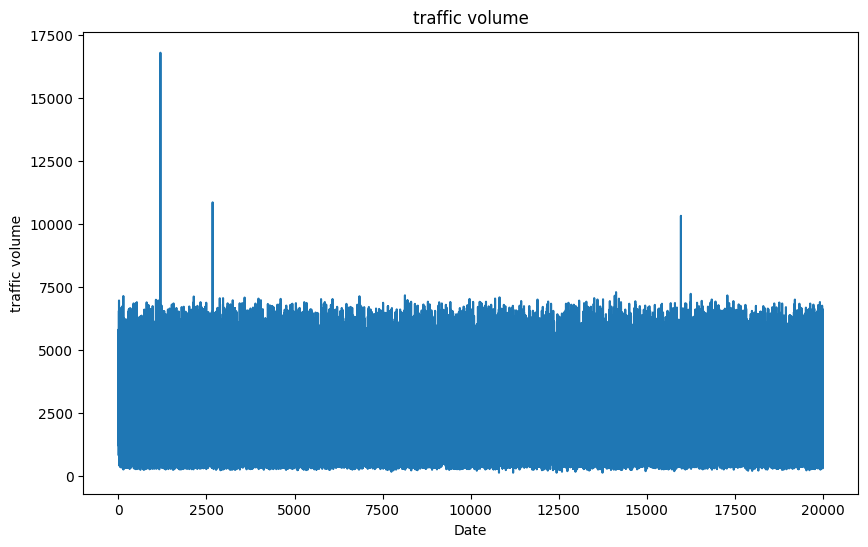

In [38]:
plt.figure(figsize=(10, 6))
plt.plot(df['traffic_volume'])
plt.title('traffic volume')
plt.xlabel('Date')
plt.ylabel('traffic volume')
plt.show()

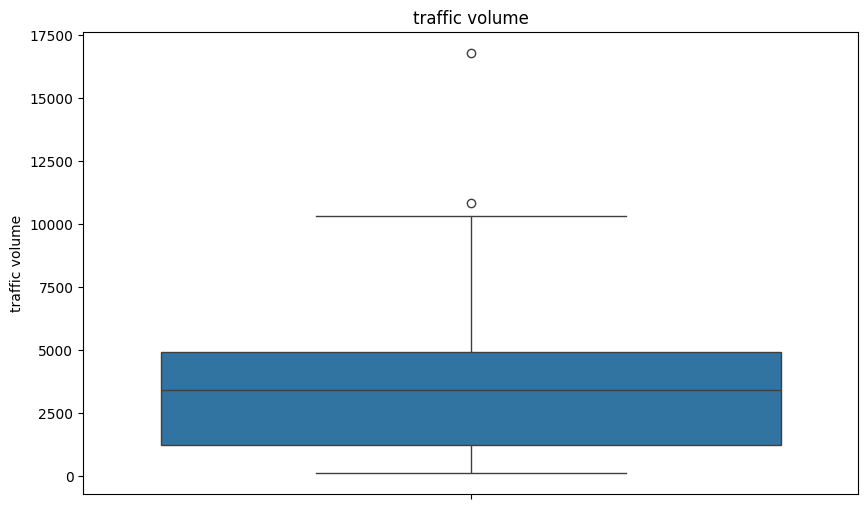

In [114]:
plt.figure(figsize=(10, 6))
sns.boxplot(df['traffic_volume'])
plt.title('traffic volume')
plt.ylabel('traffic volume')
plt.show()

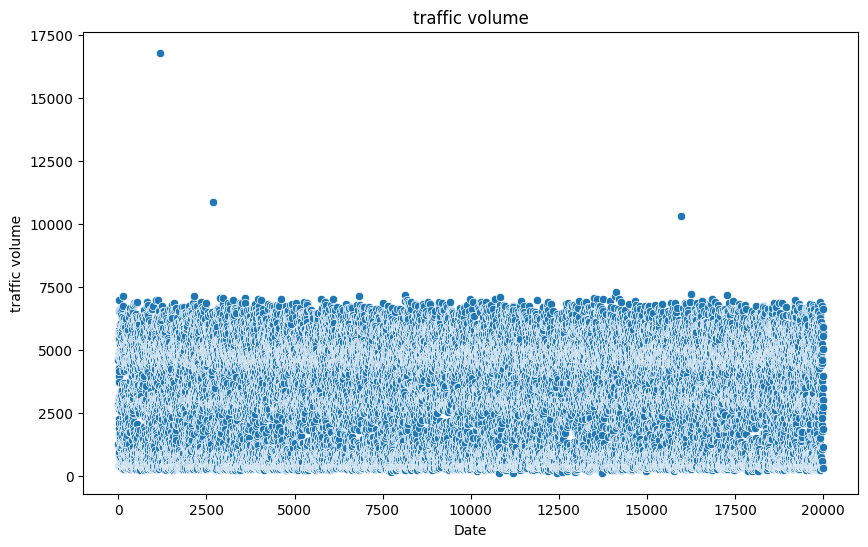

In [115]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=df.index,y=df['traffic_volume'])
plt.title('traffic volume')
plt.xlabel('Date')
plt.ylabel('traffic volume')
plt.show()

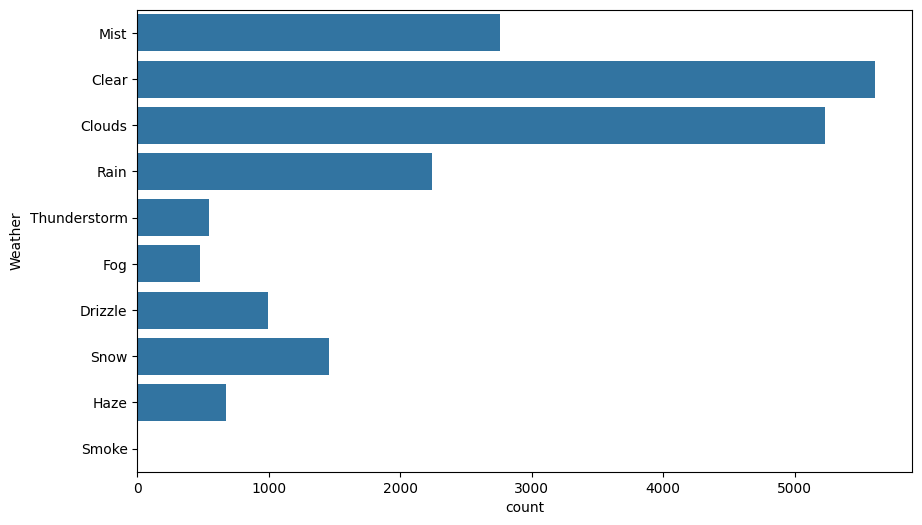

In [120]:
plt.figure(figsize=(10, 6))
sns.countplot(df['weather_main'])
plt.ylabel('Weather')
plt.show()

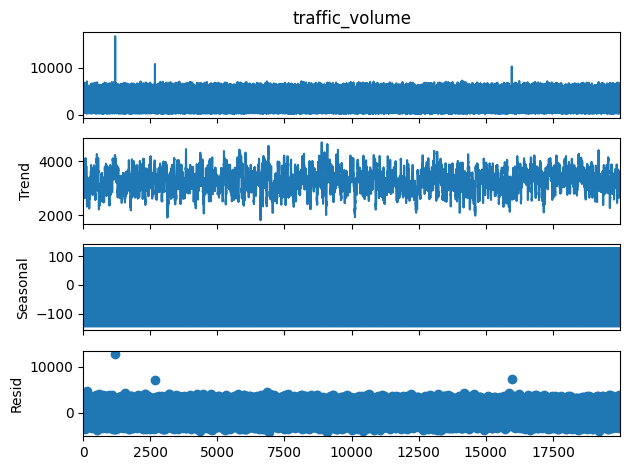

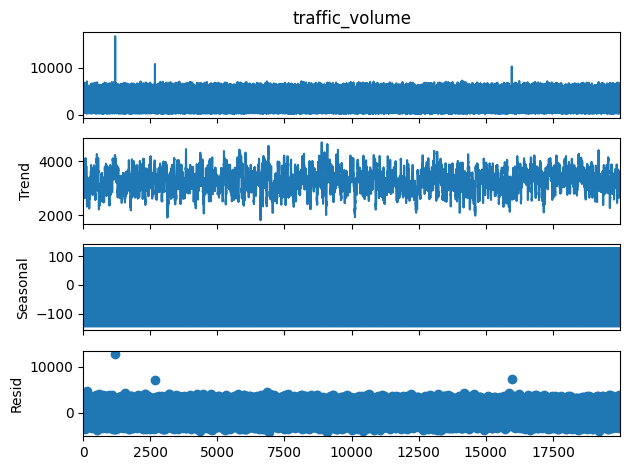

In [40]:
df.dropna(inplace=True)
seasonal_decompose(df['traffic_volume'],period=24).plot()

## Data Preprocessing

Clean and preprocess the data.

**Instructions:**
- Handle any missing values in the dataset.
- If necessary, resample the data to ensure consistent time intervals.
- Create any additional features needed, such as lags or moving averages.
- Make sure that the dates are sorted correctly.

Do more if needed!

In [41]:
df.isna().sum()

,0
traffic_volume,0
temp,0
rain_1h,0
snow_1h,0
clouds_all,0
weather_main,0
weather_description,0
date_time,0


In [42]:
df.drop_duplicates(subset='date_time',inplace=True)
df.set_index('date_time',inplace=True)

In [43]:
df.sort_values(by='date_time',inplace=True)
df.head()

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description
date_time,,,,,,,
2016-11-18 15:00:00,4872.0,274.08,0.0,0.0,90,Fog,fog
2016-11-18 16:00:00,5074.0,273.84,0.0,0.0,90,Mist,mist
2016-11-18 17:00:00,4328.0,273.62,0.0,0.0,90,Mist,mist
2016-11-18 18:00:00,3486.0,273.59,0.0,0.0,90,Snow,heavy snow
2016-11-18 19:00:00,2524.0,273.58,0.0,0.0,90,Mist,mist


In [47]:
df.drop(columns=['weather_main','weather_description'],inplace=True,axis=1)

## Feature Engineering

### Instructions:
  
- **Shift Method**: Use the `shift` method to create a new column `prev_traffic_volume`, which represents the previous day's traffic volume.

- **Difference between traffic_volume**: Calculate the difference between the values in `traffic_volume` column to highlight short-term volume.

- **Date Features**: Extract meaningful time-based features from the `date_time` column to enhance the model's ability to detect temporal patterns. These features include:
  - **Day of the week**: To capture weekly seasonality.
  - **Month**: To capture monthly trends.
  - **Day of the year**: Useful for modeling yearly seasonality.


In [44]:
df['prev_traffic_volume'] = df['traffic_volume'].shift(1)
df['diff_traffic_volume'] = df['traffic_volume'].diff()

In [45]:
df['day_of_the_week'] = df.index.dayofweek
df['month'] = df.index.month
df['day_of_the_year'] = df.index.dayofyear

In [46]:
df.sample(5)

,traffic_volume,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,prev_traffic_volume,diff_traffic_volume,day_of_the_week,month,day_of_the_year
date_time,,,,,,,,,,,,
2018-07-02 21:00:00,2552.0,299.51,0.0,0.0,40,Clouds,scattered clouds,2792.0,-240.0,0,7,183
2017-06-07 14:00:00,5070.0,301.27,0.0,0.0,1,Clear,sky is clear,4793.0,277.0,2,6,158
2017-11-08 00:00:00,548.0,271.29,0.0,0.0,90,Clouds,overcast clouds,1073.0,-525.0,2,11,312
2017-03-01 19:00:00,3200.0,271.96,0.0,0.0,90,Snow,light snow,4755.0,-1555.0,2,3,60
2017-08-15 18:00:00,4753.0,296.77,0.0,0.0,1,Clear,sky is clear,6491.0,-1738.0,1,8,227


In [ ]:
df.dropna(inplace=True)
df.head()

## Train-Test Split

Split the dataset into training and testing sets.

**Instructions:**
- Ensure the split maintains the time order of the data.
- Decide on an appropriate ratio for splitting the data.

In [48]:
# Train - Test Split after Scaling (V)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16257 entries, 2016-11-18 15:00:00 to 2018-09-30 23:00:00
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   traffic_volume       16257 non-null  float64
 1   temp                 16257 non-null  float64
 2   rain_1h              16257 non-null  float64
 3   snow_1h              16257 non-null  float64
 4   clouds_all           16257 non-null  int64  
 5   prev_traffic_volume  16256 non-null  float64
 6   diff_traffic_volume  16256 non-null  float64
 7   day_of_the_week      16257 non-null  int32  
 8   month                16257 non-null  int32  
 9   day_of_the_year      16257 non-null  int32  
dtypes: float64(6), int32(3), int64(1)
memory usage: 1.2 MB


## Feature Scaling

Apply feature scaling to the data if needed.

**Instructions:**
- Use a scaling method such as MinMaxScaler or StandardScaler.
- Ensure scaling is applied correctly to both training and testing data.

In [92]:
# new_df = df[['traffic_volume']]
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
def create_Xy(data, length):
    X = []
    y = []
    for i in range(length, len(data)):
        X.append(data[i-length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)
length = 100
X, y = create_Xy(scaled_data, length)
X = X.reshape((X.shape[0], X.shape[1], 1))

# Split the data to Train and Test
split = int(0.80 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [93]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(12924, 100, 1)
(12924,)
(3232, 100, 1)
(3232,)


## Models Selection

Choose two models for time series forecasting.

**Instructions:**
- Select two models such as ARIMA, SARIMA, RNN, LSTM, or GRU.
- Train these models and then compare their performance.

* I used RNN and LSTM
* used GRU for Testing

### Model 1 Training

Train your first model on the training dataset.

**Instructions:**
- Fit the first model to the training data.
- Ensure to monitor the training process.

# RNN Model

In [100]:
model_1 = Sequential()

In [101]:
model_1.add(SimpleRNN(units=50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model_1.add(SimpleRNN(units=50,return_sequences=True))
model_1.add(SimpleRNN(units=50,return_sequences=True))
model_1.add(Dropout(0.2))
model_1.add(SimpleRNN(units=50))
model_1.add(Dense(units=1))

In [102]:
model_1.compile(loss='mean_squared_error',optimizer='adam')

In [54]:
history1 =model_1.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 36s 95ms/step - loss: 0.2574 - val_loss: 0.0555
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 31s 95ms/step - loss: 0.0605 - val_loss: 0.0512
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 40s 93ms/step - loss: 0.0499 - val_loss: 0.0524
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - loss: 0.0479 - val_loss: 0.0459
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 30s 94ms/step - loss: 0.0425 - val_loss: 0.0484
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 40s 92ms/step - loss: 0.0395 - val_loss: 0.0477
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 41s 93ms/step - loss: 0.0471 - val_loss: 0.0454
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 30s 93ms/step - loss: 0.0375 - val_loss: 0.0451
Epoch 9/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 42s 97ms/step - loss: 0.0374 - val_loss: 0.0466
Epoch 10/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 41s 98ms/step - loss: 0.0343 - val_loss: 0.0390


### Make 1 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [55]:
y_pred_1= model_1.predict(X_test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step


### Model 1 Evaluation

Evaluate the performance of your first model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [56]:
# Calculate MSE and RMSE.
mse_rnn = mean_squared_error(y_test, y_pred_1)

rmse_rnn = mean_squared_error(y_test, y_pred_1, squared=False)

print(f"MSE SCORE: {mse_rnn}")
print(f"RMSE SCORE: {rmse_rnn}")

MSE SCORE: 0.019575833464447356
RMSE SCORE: 0.13991366432356547


Text(0.5, 1.0, 'Actual and RNN values')

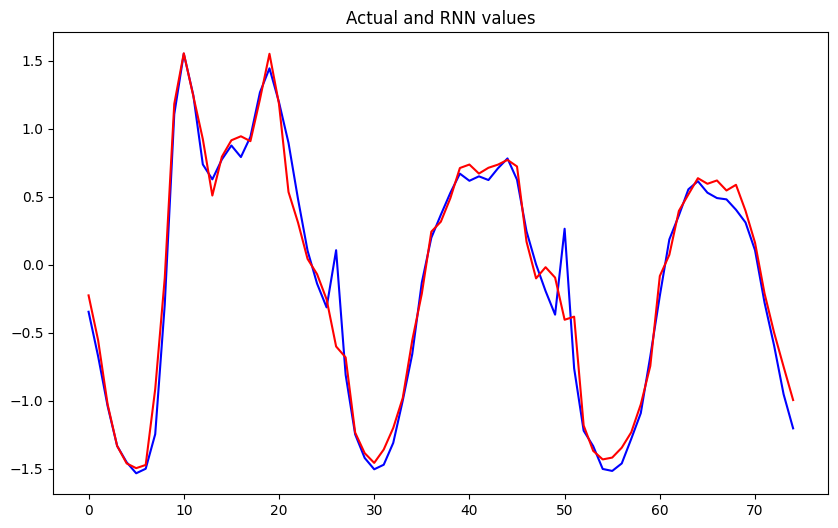

In [76]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[-75:], label='Actual',color='blue')
plt.plot(y_pred_1[-75:], label='prediction of RNN',color='red')
plt.title('Actual and RNN values')

Text(0, 0.5, 'loss')

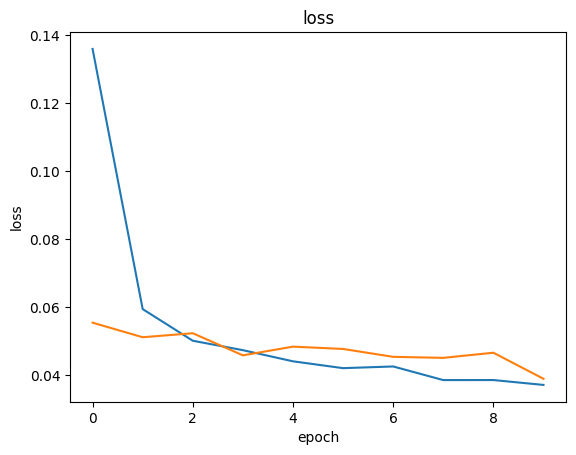

In [58]:
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

### Model 2 Training

Train your second model on the training dataset.

**Instructions:**
- Fit the second model to the training data.
- Ensure to monitor the training process.

# LSTM Model

In [59]:
model_2 = Sequential()

In [60]:
X_train.shape

(12925, 100, 1)

In [61]:
model_2.add(LSTM(units=50,return_sequences=True,input_shape=((X_train.shape[1],X_train.shape[2]))))
model_2.add(LSTM(units=50,return_sequences=True))
model_2.add(LSTM(units=50))
model_2.add(Dropout(0.2))
model_2.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [62]:
model_2.compile(loss='mean_squared_error',optimizer='adam')

In [63]:
history2=model_2.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 48s 132ms/step - loss: 0.3653 - val_loss: 0.1922
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - loss: 0.1603 - val_loss: 0.1095
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 130ms/step - loss: 0.0829 - val_loss: 0.0786
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - loss: 0.0655 - val_loss: 0.0713
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 81s 132ms/step - loss: 0.0586 - val_loss: 0.0605
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 132ms/step - loss: 0.0528 - val_loss: 0.0566
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 131ms/step - loss: 0.0505 - val_loss: 0.0540
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 42s 131ms/step - loss: 0.0462 - val_loss: 0.0585
Epoch 9/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 83s 133ms/step - loss: 0.0438 - val_loss: 0.0483
Epoch 10/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 133ms/step - loss: 0.0409 - val_loss: 0.0511


### Make 2 Predictions

Generate predictions on the test dataset.

### Instructions:
- Use the trained model to make predictions on the test data.
- Store the predictions for further analysis.

In [64]:
y_pred_2 = model_2.predict(X_test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step


### Model 2 Evaluation

Evaluate the performance of your second model on the test dataset.

**Instructions:**
- Calculate evaluation metrics such as MAE, MSE, RMSE, or MAPE.
- Plot the predicted vs actual values for the test set.
- Plot the loss and the validation loss.

In [65]:
# Calculate MSE and RMSE.
mse_lstm = mean_squared_error(y_test, y_pred_2)

rmse_lstm = mean_squared_error(y_test, y_pred_2, squared=False)

print(f"MSE SCORE: {mse_lstm}")
print(f"RMSE SCORE: {rmse_lstm}")

MSE SCORE: 0.026613467490785657
RMSE SCORE: 0.16313634632044957


Text(0.5, 1.0, 'Actual and LSTM values')

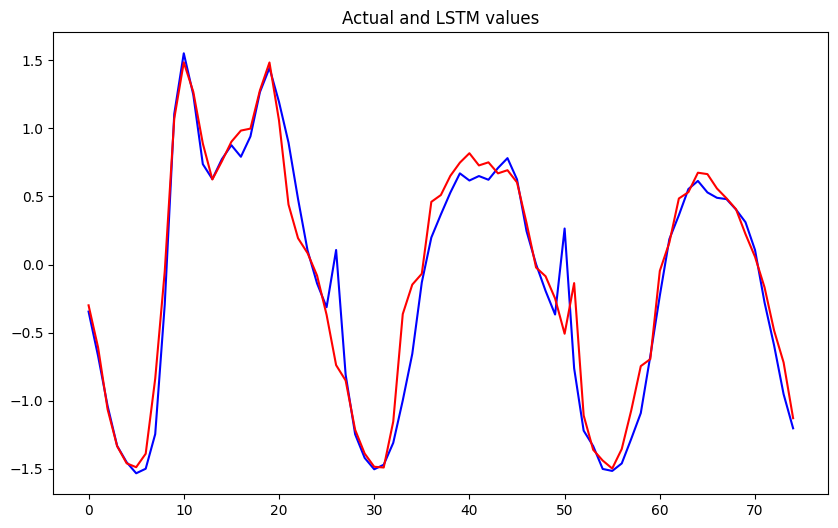

In [78]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[-75:], label='Actual',color='blue')
plt.plot(y_pred_2[-75:], label='prediction of LSTM',color='red')
plt.title('Actual and LSTM values')

Text(0, 0.5, 'loss')

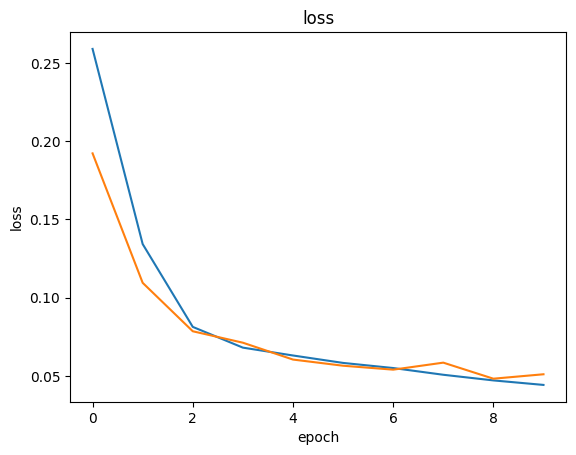

In [67]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

# GRU Model for testing

In [68]:
model_3 = Sequential()

In [69]:
model_3.add(GRU(units=50,return_sequences=True,input_shape=(X_train.shape[1],X_train.shape[2])))
model_3.add(GRU(units=50,return_sequences=True))
model_3.add(GRU(units=50))
model_3.add(Dense(units=1))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [70]:
model_3.compile(loss='mean_squared_error',optimizer='adam')

In [71]:
history3=model_3.fit(X_train,y_train,epochs=10,batch_size=32,validation_split=0.2)

Epoch 1/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 62s 175ms/step - loss: 0.2875 - val_loss: 0.0705
Epoch 2/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 56s 173ms/step - loss: 0.0495 - val_loss: 0.0550
Epoch 3/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 175ms/step - loss: 0.0415 - val_loss: 0.0481
Epoch 4/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 81s 173ms/step - loss: 0.0372 - val_loss: 0.0452
Epoch 5/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 83s 177ms/step - loss: 0.0349 - val_loss: 0.0442
Epoch 6/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - loss: 0.0334 - val_loss: 0.0439
Epoch 7/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 173ms/step - loss: 0.0322 - val_loss: 0.0439
Epoch 8/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 83s 175ms/step - loss: 0.0311 - val_loss: 0.0441
Epoch 9/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 81s 174ms/step - loss: 0.0301 - val_loss: 0.0443
Epoch 10/10
324/324 ━━━━━━━━━━━━━━━━━━━━ 82s 174ms/step - loss: 0.0292 - val_loss: 0.0443


In [72]:
y_pred_3 = model_3.predict(X_test)

101/101 ━━━━━━━━━━━━━━━━━━━━ 5s 46ms/step


In [73]:
# Calculate MSE and RMSE.
mse_gru = mean_squared_error(y_test, y_pred_3)

rmse_gru = mean_squared_error(y_test, y_pred_3, squared=False)

print(f"MSE SCORE: {mse_gru}")
print(f"RMSE SCORE: {rmse_gru}")

MSE SCORE: 0.022654836973231438
RMSE SCORE: 0.15051523834227362


Text(0.5, 1.0, 'Actual and GRU values')

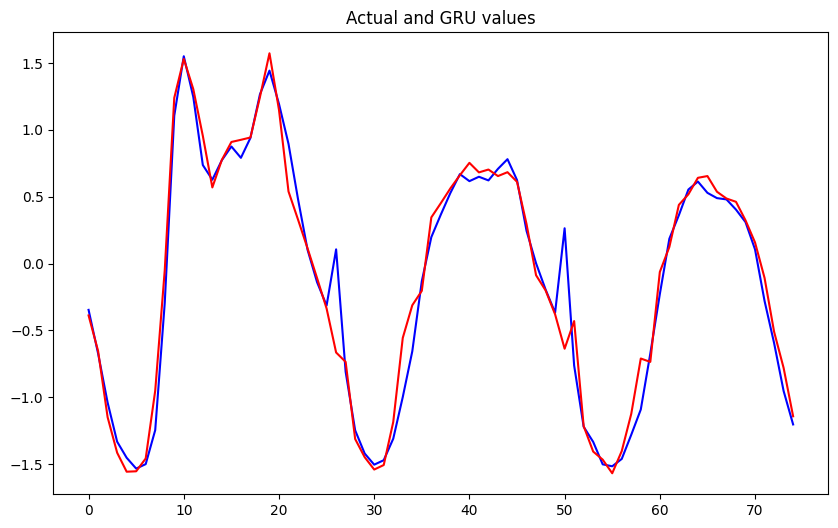

In [79]:
plt.figure(figsize=(10, 6))
plt.plot(y_test[-75:], label='Actual',color='blue')
plt.plot(y_pred_3[-75:], label='prediction of GRU',color='red')
plt.title('Actual and GRU values')

Text(0, 0.5, 'loss')

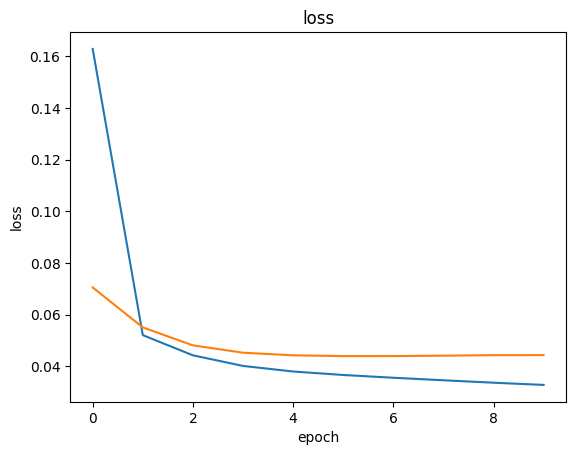

In [75]:
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('loss')
plt.xlabel('epoch')
plt.ylabel('loss')

## Project Questions:

1. **Data Preprocessing**: Explain How you chose your specific data preprocessing techniques (e.g., normalization, handling missing values). How did these techniques help prepare the data for training the model?
2. **Feature Engineering**: Did you perform any feature engineering or transformations? Describe your decisions and how these new features (or transformed features) contributed to the forecasting model.
3. **Model Architecture**: Describe the reasoning behind your model’s architecture (e.g., the type of model, layers, number of neurons, and activation functions). Why did you believe this architecture was appropriate for time series forecasting?
4. **Training Process**: Discuss why you chose your batch size, number of epochs, and optimizer. How did these choices affect the training process? Did you experiment with different values, and what were the outcomes?
5. **Loss Function and Metrics**: Why did you choose the specific loss function and evaluation metrics (e.g., MAE, RMSE, MAPE)? How do they align with the objective of forecasting?
6. **Model Tuning (If Done)**: Describe any tuning you performed (e.g., hyperparameter tuning) and why you felt it was necessary. How did these adjustments improve model performance?
7. **Overfitting and Underfitting**: Analyze whether the model encountered any overfitting or underfitting during training. What strategies could you implement to mitigate these issues?
8. **Future Improvements**: Suggest potential improvements or further steps you could take to enhance model performance. Consider using different algorithms, feature engineering techniques, or tuning hyperparameters.

### Answer Here:

###Data Preprocessing
* I handle missing values by dropping them.
* The traffic volume data was scaeled using StandardScaler

###Feature Engineering
* I created prev_traffic_volume and diff_traffic_volume to include past traffic volume and their diffrences
* day_of_the_week, month, and day_of_the_year provide context about seasonal and daily patterns.

###Model Architecture
* RNN Model: Consists of four SimpleRNN layers with one dropout.
* LSTM Model: Consists of three LSTM layers with one dropout
* testing- GRU Model :Consists of three GRU layers, which are often less computationally intensive compared to LSTM but can still capture temporal dependencies effectively.

###Training Process
* Batch Size: 32 for all three models,Smaller batch sizes can help in faster convergence but may introduce more noise.
* Number of Epochs : is 10 for all models, Due to low CPU Power on google colab
* Optimizer : ADAM, which is generally a good choice for its adaptive learning rate.

###Loss Function and Metrics
* Loss Function : Mean Squared Error (MSE), which measures the average squared difference between predicted and actual values.
RMSE (Root Mean Squared Error) provides a more interpretable measure of prediction error in the same units as the target variable.

###Overfitting and Underfitting
* using Dropout layer to prevent overfitting
* GRU model is overfitting

###Future Improvements
* Try Different Models: Using Different model like ARIMA or SARIMA.
* Tuning: Use techniques like Grid Search or Random Search for more optimal hyperparameter values.
* Increase Epochs: Train for more epochs.
